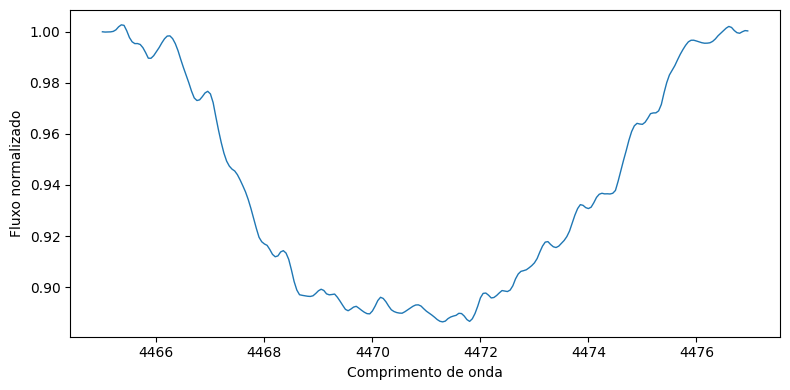

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import curve_fit


# ==============================================================
# Leitura do arquivo FITS
# ==============================================================

fits_file = "_hd22192_20251014_933_50.fits"

a = 2

with fits.open(fits_file) as hdul:
    header = hdul[0].header
    flux   = hdul[0].data

date = header["MID-HJD"]
hcor = header["BSS_RQVH"]

# ==============================================================
# Construção do eixo de comprimento de onda
# ==============================================================

wl_start = header["CRVAL1"]
wl_step  = header["CDELT1"]
n_pix    = header["NAXIS1"]

wl = wl_start + wl_step * np.arange(n_pix)

# ==============================================================
# Seleção da região espectral
# ==============================================================

idx_min, idx_max = 950, 1190

wl_region   = wl[idx_min:idx_max]
flux_region = flux[idx_min:idx_max]

# ==============================================================
# Ajuste do contínuo (linear)
# ==============================================================

def linear_model(x, a, b):
    """Modelo linear para ajuste do contínuo."""
    return a * x + b


# Usa apenas as bordas da região para ajustar o contínuo
wl_edges   = np.concatenate([wl_region[:5],  wl_region[-5:]])
flux_edges = np.concatenate([flux_region[:5], flux_region[-5:]])

params, cov = curve_fit(
    linear_model,
    wl_edges,
    flux_edges,
    p0=[1e-3, 9.7e5]
)

a_fit, b_fit = params

# ==============================================================
# Normalização do espectro
# ==============================================================

continuum = linear_model(wl_region, a_fit, b_fit)
flux_norm = flux_region / continuum

# Erro (exemplo simples)
flux_err = 0.1 * flux_region

# ==============================================================
# Plot
# ==============================================================

plt.figure(figsize=(8, 4))
plt.plot(wl_region, flux_norm, lw=1)
plt.xlabel("Comprimento de onda")
plt.ylabel("Fluxo normalizado")
plt.tight_layout()
plt.show()


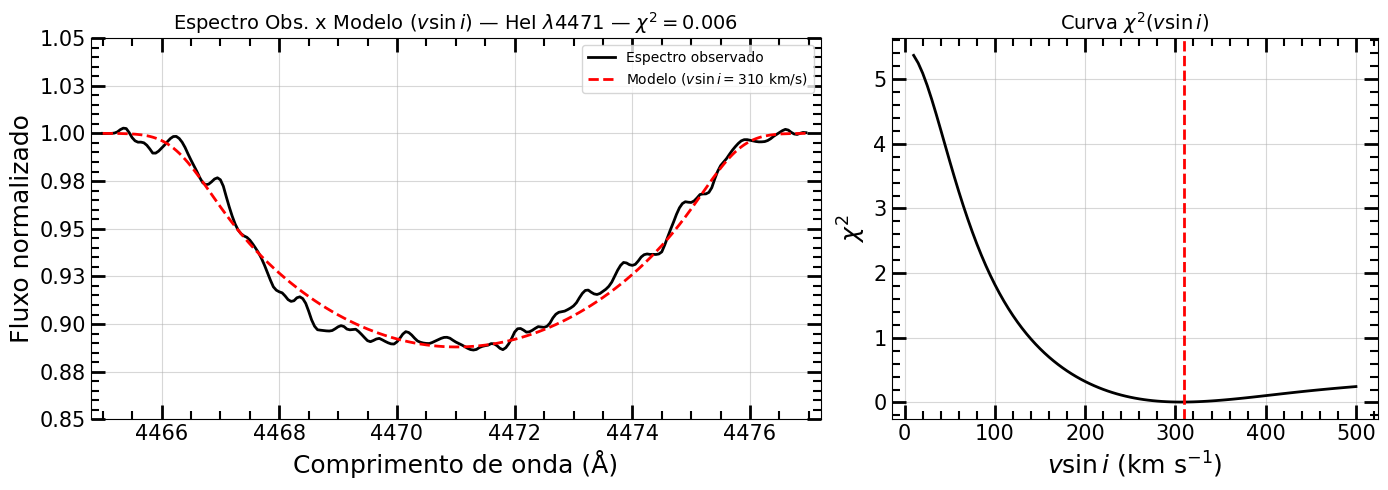

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from ipywidgets import interact, FloatSlider
from IPython.display import display
import ipywidgets as widgets
from matplotlib.ticker import FormatStrFormatter

# =============================
# DADOS OBSERVADOS (NORMALIZADOS)
# =============================
# wl1   → comprimento de onda observado (Å)
# flux3 → fluxo normalizado

# =============================
# PARÂMETROS FIXOS
# =============================
wl0 = 4471.0
wl_full = np.linspace(wl0-25, wl0+25, 4000)

c = 299792.458  # km/s

# =============================
# FUNÇÕES DO MODELO
# =============================
def gaussian_line(wl, depth, sigma):
    return 1.0 - depth * np.exp(
        -((wl - wl0)**2)/(2*sigma**2)
    )

def rot_profile(wl, wl0, vsini, eps=0.6):
    delta = (wl - wl0)/wl0 * c
    x = delta / vsini

    profile = np.zeros_like(x)
    mask = np.abs(x) <= 1

    profile[mask] = (
        (2*(1-eps)*np.sqrt(1-x[mask]**2)) +
        (0.5*np.pi*eps*(1-x[mask]**2))
    ) / (np.pi*vsini*(1-eps/3))

    profile /= np.trapezoid(profile, wl)
    return profile

def inst_profile(wl, wl0, R):
    delta_lambda = wl0 / R
    sigma_inst = delta_lambda / (2*np.sqrt(2*np.log(2)))

    profile = np.exp(
        -0.5*((wl - wl0)/sigma_inst)**2
    )
    profile /= np.trapezoid(profile, wl)
    return profile

def convolve_rot_inst(flux, wl, wl0, vsini, R, eps):
    if vsini == 0:
        profile_rot = np.zeros_like(wl)
        profile_rot[len(wl)//2] = 1.0
    else:
        profile_rot = rot_profile(wl, wl0, vsini, eps)

    profile_inst = inst_profile(wl, wl0, R)
    profile_total = np.convolve(profile_rot, profile_inst, mode='same')
    profile_total /= np.trapezoid(profile_total, wl)

    conv_flux = np.convolve(flux, profile_total, mode='same')
    conv_flux /= np.max(conv_flux)  # mantém comportamento original

    return conv_flux

# =============================
# CHI²
# =============================
def compute_model_and_chi2(vsini, depth, sigma, wl_obs, flux_obs, R, eps):

    flux_intrinsic = gaussian_line(wl_full, depth, sigma)

    flux_model = convolve_rot_inst(
        flux_intrinsic, wl_full, wl0, vsini, R, eps
    )

    interp_model = interp1d(
        wl_full, flux_model,
        kind='linear',
        bounds_error=False,
        fill_value=1.0
    )

    flux_model_obs = interp_model(wl_obs)
    chi2 = np.sum((flux_obs - flux_model_obs)**2)

    return flux_model_obs, chi2

# =============================
# PLOT DUPLO INTERATIVO
# =============================
def plot_vsini_and_chi2(
    vsini=150, depth=0.4, sigma=0.15, R=10000, eps=0.6,
    show_obs=True, show_model=True, save=False
):

    # =============================
    # MODELO + CHI²
    # =============================
    flux_model_obs, chi2 = compute_model_and_chi2(
        vsini, depth, sigma, wl_region, flux_norm, R, eps
    )

    vsini_grid = np.arange(10, 501, 5)
    chi2_grid = []

    for v in vsini_grid:
        _, chi2_v = compute_model_and_chi2(
            v, depth, sigma, wl_region, flux_norm, R, eps
        )
        chi2_grid.append(chi2_v)

    chi2_grid = np.array(chi2_grid)

    # =============================
    # FIGURA
    # =============================
    fig, axs = plt.subplots(
        1, 2, figsize=(14, 5),
        gridspec_kw={'width_ratios': [3, 2]}
    )

    # =============================
    # PAINEL DO ESPECTRO
    # =============================
    axs[0].set_xlim(4464.8, 4477.2)
    axs[0].set_ylim(0.85, 1.05)

    axs[0].set_xlabel('Comprimento de onda (Å)', size=18)
    axs[0].set_ylabel('Fluxo normalizado', size=18)
    axs[0].set_title(
        rf'Espectro Obs. x Modelo ($v\sin i$) — HeI $\lambda4471$'
        rf' — $\chi^2={chi2:.3f}$',
        size=14
    )

    axs[0].minorticks_on()
    axs[0].tick_params(
        axis='both', which='major', direction='in',
        top=True, right=True, length=10, width=2, labelsize=15
    )
    axs[0].tick_params(
        axis='both', which='minor', direction='in',
        top=True, right=True, length=6, width=1.5
    )
    axs[0].yaxis.set_major_formatter(
        FormatStrFormatter('%.2f')
    )

    # --- Plot condicional ---
    if show_obs:
        axs[0].plot(
            wl_region, flux_norm,
            'k', lw=2.0,
            label='Espectro observado'
        )

    if show_model:
        axs[0].plot(
            wl_region, flux_model_obs,
            'r--', lw=2.0,
            label=fr'Modelo ($v\sin i={vsini:.0f}$ km/s)'
        )

    if show_obs or show_model:
        axs[0].legend()

    axs[0].grid(alpha=0.5)

    # =============================
    # PAINEL DO CHI²
    # =============================
    axs[1].set_title(r'Curva $\chi^2(v\sin i)$', size=14)
    axs[1].set_xlabel(r'$v\sin i$ (km s$^{-1}$)', size=18)
    axs[1].set_ylabel(r'$\chi^2$', size=18)

    axs[1].minorticks_on()
    axs[1].tick_params(
        axis='both', which='major', direction='in',
        top=True, right=True, length=10, width=2, labelsize=15
    )
    axs[1].tick_params(
        axis='both', which='minor', direction='in',
        top=True, right=True, length=6, width=1.5
    )

    axs[1].plot(vsini_grid, chi2_grid, 'k-', lw=2)
    axs[1].axvline(vsini, color='r', ls='--', lw=2)

    axs[1].grid(alpha=0.5)

    plt.tight_layout()

    # =============================
    # SALVAR FIGURA
    # =============================
    if save:
        fname = f"vsini_{int(vsini)}_R{int(R)}.pdf"
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f'Figura salva como {fname}')

    plt.show()


# =============================
# INTERATIVIDADE
# =============================
'''
interact(
    plot_vsini_and_chi2,
    vsini=FloatSlider(min=10, max=400, step=5, value=150, description='v sin i'),
    depth=FloatSlider(min=0.05, max=0.9, step=0.05, value=0.4, description='d'),
    sigma=FloatSlider(min=0.05, max=0.5, step=0.01, value=0.15, description='σ (Å)'),
    R=FloatSlider(min=5000, max=20000, step=1000, value=10000, description='R'),
    eps=FloatSlider(min=0, max=1, step=0.05, value=0.6, description='ε')
)'''

# =============================
# SLIDERS
# =============================
from IPython.display import display, HTML

display(HTML("""
<style>
.widget-label {
    font-size: 18px !important;
    font-weight: bold;
}
.widget-readout {
    font-size: 18px !important;
    font-weight: bold;
}
</style>
"""))

show_obs = widgets.Checkbox(
    value=True,
    description='Espectro observado'
)

show_model = widgets.Checkbox(
    value=True,
    description='Modelo teórico'
)

vsini_slider = widgets.FloatSlider(
    min=10, max=500, step=5, value=150,
    description='vsini', readout_format='d',
    continuous_update=False
)
vsini_slider.style.handle_color = 'red'
#vsini_slider.style.description_width = '60px'

depth_slider = widgets.FloatSlider(
    min=0.05, max=0.9, step=0.05, value=0.4,
    description='A_0',
    continuous_update=False
)
depth_slider.style.handle_color = 'black'

sigma_slider = widgets.FloatSlider(
    min=0.05, max=0.5, step=0.01, value=0.15,
    description='σ',
    continuous_update=False
)
sigma_slider.style.handle_color = 'black'

R_slider = widgets.FloatSlider(
    min=5000, max=20000, step=1000, value=10000,
    description='R', readout_format='d',
    continuous_update=False
)
R_slider.style.handle_color = 'black'

eps_slider = widgets.FloatSlider(
    min=0, max=1, step=0.05, value=0.6,
    description='ε',
    continuous_update=False
)
eps_slider.style.handle_color = 'black'

save_button = widgets.Button(
    description='Salvar figura',
    icon='save',
    button_style='success'
)

# largura dos sliders (estética)
for w in [vsini_slider, depth_slider, sigma_slider, R_slider, eps_slider, save_button]:
    w.layout.width = '320px'

def save_figure(b):

    # pega valores atuais dos sliders
    vsini = vsini_slider.value
    depth = depth_slider.value
    sigma = sigma_slider.value
    R = R_slider.value
    eps = eps_slider.value

    # cria figura
    plot_vsini_and_chi2(
        vsini=vsini,
        depth=depth,
        sigma=sigma,
        R=R,
        eps=eps,
        save=True
    )

save_button.on_click(save_figure)

title_sliders = widgets.HTML(
    value="""
    <div style="
        font-size:20px;
        font-weight:bold;
        text-align:center;
        margin-bottom:28px;
        border-bottom:2px solid #444;
        padding-bottom:4px;">
           Ajuste dos Parâmetros Espectrais
    </div>
    """
)

# =============================
# LIGA SLIDERS À FUNÇÃO
# =============================
toggle_box = widgets.VBox(
    [show_obs, show_model],
    layout=widgets.Layout(margin='10px 0px 10px 0px')
)

ui = widgets.VBox([
    title_sliders,
    toggle_box,
    vsini_slider,
    depth_slider,
    sigma_slider,
    R_slider,
    eps_slider,
    save_button
],
    layout=widgets.Layout(
        #padding='10px 20px 10px 10px',
        margin='80px 10px 0px 0px',
        #width='300px'
    )
)

out = widgets.interactive_output(
    plot_vsini_and_chi2,
    {
        'show_obs': show_obs,
        'show_model': show_model,
        'vsini': vsini_slider,
        'depth': depth_slider,
        'sigma': sigma_slider,
        'R': R_slider,
        'eps': eps_slider
    }
)

# =============================
# DISPLAY LADO A LADO
# =============================
display(widgets.HBox([ui, out]))